In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

{'absent': 0, 'free': 1, 'occupied': 2}


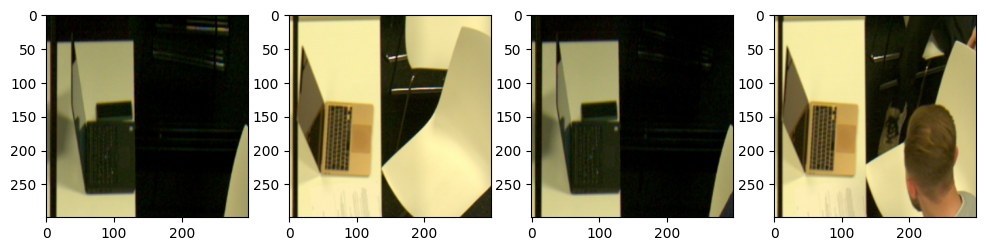

In [113]:
data_dir = '../data/training_data'

transform = v2.Compose([
    v2.Resize((299, 299)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_set = ImageFolder(data_dir, transform=transform)

print(data_set.class_to_idx)

fig, ax = plt.subplots(figsize=(12,8), ncols=4)
for i in range(4):
    image, label = data_set[i]

    rgb_img = (image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    
    ax[i].imshow(rgb_img)

In [114]:
train_size = int(0.8 * len(data_set))
valid_size = int(0.05 * len(data_set))
test_size = len(data_set) - train_size - valid_size

train_set, valid_set, test_set = torch.utils.data.random_split(data_set, [train_size, valid_size, test_size])

In [115]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(valid_loader)

def validate_accuracy(model, valid_loader, device):
    pred = []
    true = []
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            pred += predicted.cpu().numpy().tolist()
            true += labels.numpy().tolist()

    pred = np.array(pred)
    true = np.array(true)

    accuracy = (true == pred).sum() / len(true)
    return accuracy

def plot_losses(train_losses, valid_losses, valid_accuracy):
    plt.cla()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    display(plt.gcf())
    clear_output(wait=True)

def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device, plot=True):
    model.to(device)
    model.train()

    train_losses = []
    valid_losses = []
    valid_accuracy = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        avg_train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(avg_train_loss)

        avg_val_loss = validate(model, valid_loader, criterion, device)
        valid_losses.append(avg_val_loss)

        accuracy = validate_accuracy(model, valid_loader, device)
        valid_accuracy.append(accuracy)

        scheduler.step()

        if plot:
            print(f'Epoch: {epoch+1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}, Best Accuracy: {max(accuracy, best_accuracy):.2%}')
            plot_losses(train_losses, valid_losses, valid_accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model_name = f'ResNet18_pretrained-epoch{epoch}-accuracy{best_accuracy:.4f}.pt'
            torch.save(model.cpu(), '../models/checkpoint.pt')
            model.to(device)

    os.rename('../models/checkpoint.pt', '../models/' + model_name)
    print(f'Model saved as {model_name}')

    return best_accuracy, model_name

In [116]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.IMAGENET1K_V1')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.IMAGENET1K_V1')

Using cache found in /home/tim/.cache/torch/hub/pytorch_vision_v0.10.0


Model saved as ResNet18_pretrained-epoch5-accuracy0.8214.pt
Best Validation Accuracy: 82.14%


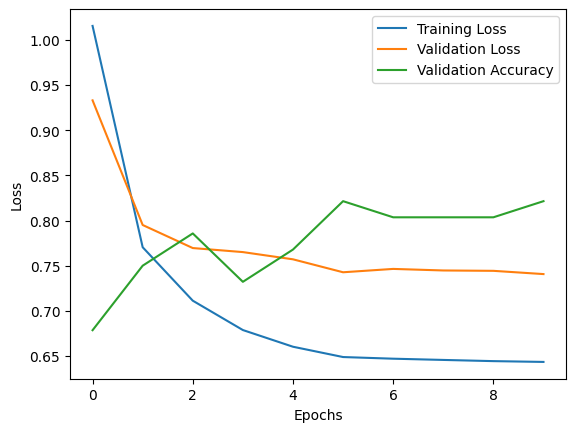

In [118]:
batch_size = 32
num_epochs = 10

for param in model.parameters():
    param.requires_grad = False

num_classes = len(data_set.class_to_idx)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
best_accuracy, model_name = train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs, device)
print(f'Best Validation Accuracy: {best_accuracy:.2%}')

Accuracy: 92.26%


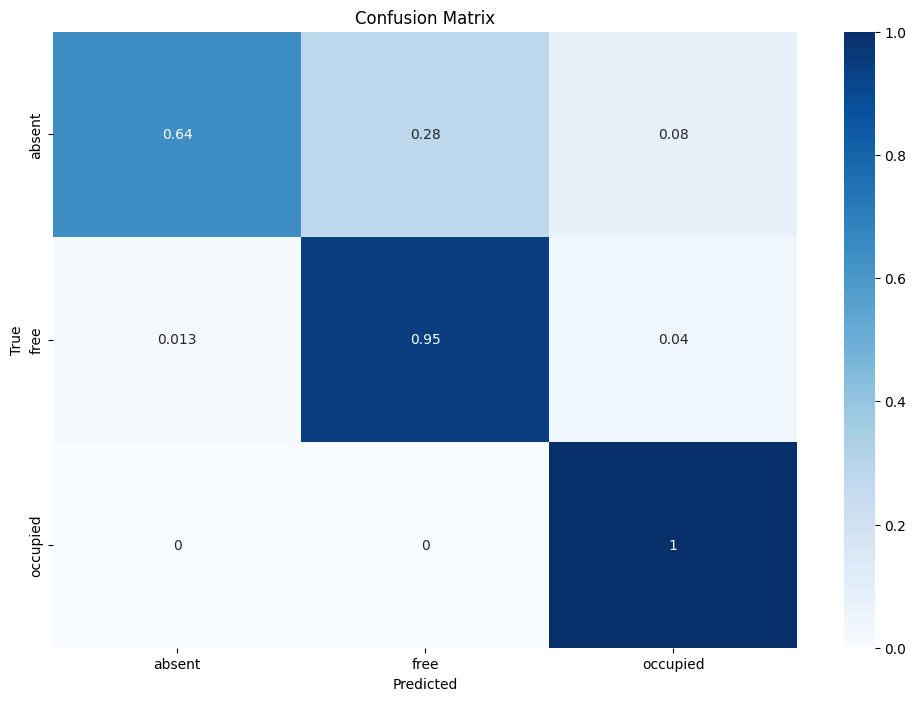

In [121]:
def plot_confusion_matrix(model, data_loader, device):
    pred = []
    true = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            pred += predicted.cpu().numpy().tolist()
            true += labels.numpy().tolist()

    pred = np.array(pred)
    true = np.array(true)

    cm = confusion_matrix(true, pred, normalize='true')
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(num_classes) + 0.5, data_set.classes)
    plt.yticks(np.arange(num_classes) + 0.5, data_set.classes)
    plt.show()

model.to(device)
test_loader = DataLoader(test_set, batch_size=batch_size)
test_accuracy = validate_accuracy(model, test_loader, device)
print(f'Accuracy: {test_accuracy:.2%}')
plot_confusion_matrix(model, test_loader, device)
model_name = f'ResNet18_pretrained-accuracy{test_accuracy:.4f}.pt'
torch.save(model.cpu(), '../models/' + model_name)